# Contents 
1) Data pre-processing 

2) Training, Validation, Test set 

3) LSTM Model construction 

4) Training 

5) Test 



In [ ]:
!mkdir data
!wget -c https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/labels.txt
!wget -c https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/reviews.txt
!mv *.txt data/

mkdir: cannot create directory ‘data’: File exists
--2022-10-07 10:02:38--  https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/labels.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agungsantoso/deep-learning-v2-pytorch/master/sentiment-rnn/data/labels.txt [following]
--2022-10-07 10:02:38--  https://raw.githubusercontent.com/agungsantoso/deep-learning-v2-pytorch/master/sentiment-rnn/data/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225000 (220K) [text/plain]
Saving to: ‘labels.txt’

labels.txt          100%[===================>] 219.73K  --.

In [ ]:
import numpy as np

with open('data/reviews.txt', 'r') as f:
  reviews = f.read() # long string 
with open('data/labels.txt', 'r') as f:
  labels = f.read() # long string


In [ ]:
reviews[:700]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student we'

In [ ]:
labels[:200]

'positive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npo'

#Data pre-processing

In [ ]:
from string import punctuation

reviews = reviews.lower() 
all_text = ''.join([c for c in reviews if c not in punctuation]) # To remove punctuations 

reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

words = all_text.split()


'_'.join(['a','b','c'])='a_b_c' \\
string(=string1 string2 ...).split()= [ string1, string2, ...] 




In [ ]:
reviews_split[:2]

['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ',
 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  viol

In [ ]:
words[:10]

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']

In [ ]:
from collections import Counter


counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)} 

reviews_ints = [] # reveiw in reveiws_ints, review = [ noun1, noun2, noun3,...]
for review in reviews_split:
  reviews_ints.append([vocab_to_int[word] for word in review.split()])

dict(counter(iterable) )('the')= 336713 \
counts.get = fn, counts.get('the')= 336713 \\
sorted(iterable object, fn, reverse )  \\
list(enumerate(['a','b',c'],1) )=[ (1, 'a'), (2,'b'), (3,'c')  


In [ ]:
print(next(iter(counts.items())))
print(counts.get('the'))
print(vocab[:10])
print(reviews_split[0].split()[:10])
reviews_ints[0][:10]

('bromwell', 8)
336713
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i']
['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']


[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1]

#Encoding the labels


In [ ]:
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

positive -> 1
negative -> 0

#Removing Outliers 

In [ ]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [ ]:
print('Number of reviews before removing outliers: ', len(reviews_ints))
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]


reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


In [ ]:
def pad_features(reviews_ints, seq_length):

    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    for i, row in enumerate(reviews_ints):
      features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [ ]:
seq_length = 200
features = pad_features(reviews_ints, seq_length=seq_length)


#Training, Validation, Test Dataset


In [ ]:
split_frac = 0.8

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\tFeatures Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))


			Features Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


torch.from_numpy(array)->tensor \\

TensorDataset( tensor1, tensor2 )=> (x,y), x in tensor1 and y in tensor2 \\

DataLoader( { (x_i,y_i) }, shuffle, batch_size ) => next(iter(DataLoader( ))[0]=torch(x_i,y_i) \\




In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


batch_size = 50


train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     2, 13732, 12906],
        [    0,     0,     0,  ...,     4,  3605, 14016],
        [23673,     6,     1,  ...,    17,     1,  1375],
        ...,
        [    0,     0,     0,  ...,   370,     5,    21],
        [    0,     0,     0,  ...,   316,    11,  1128],
        [    0,     0,     0,  ...,  1401,   434,  1521]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1])


#Long Short-Term Memory(LSTM) 


lstm-3.svg

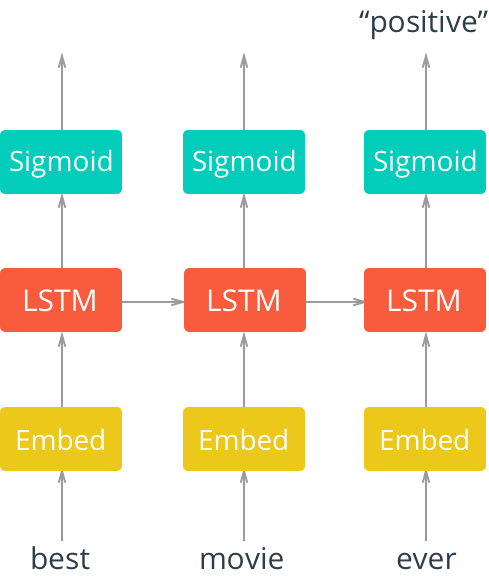

**Dataset setting** \\
* $h$ = hidden units \\
* the batch size = $n$ \\
* the number of inputs = embedding_dim= $d$ \\

the input = $\mathbf{X}_{t} \in \mathbb{R}^{n \times d}$  \\ 
the hidden state of the previous time step = $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. \\

**Three gates** \\
1) input gate =  $\mathbf{I}_{t} =\sigma\left(\mathbf{X}_{t} \mathbf{W}_{x i}+\mathbf{H}_{t-1} \mathbf{W}_{h i}+\mathbf{b}_{i}\right)  \in \mathbb{R}^{n \times h} $ \\
2) the forget gate = $\mathbf{F}_{t}  =\sigma\left(\mathbf{X}_{t} \mathbf{W}_{x f}+\mathbf{H}_{t-1} \mathbf{W}_{h f}+\mathbf{b}_{f}\right) \in \mathbb{R}^{n \times h}$ \\
3) the output gate = $\mathbf{O}_{t} =\sigma\left(\mathbf{X}_{t} \mathbf{W}_{x o}+\mathbf{H}_{t-1} \mathbf{W}_{h o}+\mathbf{b}_{o}\right) \in \mathbb{R}^{n \times h}$. 
$$
$$
where $\mathbf{W}_{x i}, \mathbf{W}_{x f}, \mathbf{W}_{x o} \in \mathbb{R}^{d \times h}$, \\
and $\mathbf{W}_{h i}, \mathbf{W}_{h f}, \mathbf{W}_{h o} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_{i}, \mathbf{b}_{f}, \mathbf{b}_{o} \in \mathbb{R}^{1 \times h}$ are bias parameters.

**Candidate Memory cell**
$$
\tilde{\mathbf{C}}_{t}=\tanh \left(\mathbf{X}_{t} \mathbf{W}_{x c}+\mathbf{H}_{t-1} \mathbf{W}_{h c}+\mathbf{b}_{c}\right)
$$
where $\mathbf{W}_{x c} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{h c} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_{c} \in \mathbb{R}^{1 \times h}$ is a bias parameter.

**Memoery Cell**
$$
\mathbf{C}_{t}=\mathbf{F}_{t} \odot \mathbf{C}_{t-1}+\mathbf{I}_{t} \odot \tilde{\mathbf{C}}_{t}
$$

**Hidden State**
$$
\mathbf{H}_{t}=\mathbf{O}_{t} \odot \tanh \left(\mathbf{C}_{t}\right)
$$

In [ ]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


Paremeters of the SemtimentRNN

* vocab_size 
* output_size \\
notice: output_size $\neq$ dim(output gate)(=hidden_dim)

* embedding_dim
* hidden_dim
* n_layers
* drop_prob 

The layers of the sentimentRNN \\
1) embedding layer: seq of ints -> vector \\
2) LSTM layer: vector -> (output, (cn, hn)) \\
3) FC layer: output-> 

input $x$-> $\phi(x)$ = embedding(x) $\in \mathbb{R}^{\text{embedding_dim}} $ \\



**Building block** \\
1) nn.Embedding \\
* torch.nn.Embedding(num_embeddings, embedding_dim) 
* Input: IntTensor or LongTensor of arbitrary shape containing the indices to extract\\
* Output: H(∗,H), where * is the input shape and H= embedding_dim




In [ ]:
import torch.nn as nn
# nn.Embedding 
a = torch.LongTensor([0,1,2])
embedding = nn.Embedding(3,5)
print(embedding(a).shape, '\n', embedding(a))

torch.Size([3, 5]) 
 tensor([[ 0.5304, -0.5410,  0.1449,  0.0748, -2.0539],
        [-0.2518,  1.3823,  0.7147,  0.6111, -0.0841],
        [ 1.0671,  0.0625,  0.3189, -0.8205,  1.5674]],
       grad_fn=<EmbeddingBackward0>)




2) nn.LSTM \\
  (Parameter)
* input_size = The number of expected features in the input x
* hidden_size = The number of features in the hidden state h
* num_layers = Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
* bias = If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0 \\
* batch_first : default = False \\


(inputs) (h_0, c_0) \\
*  input: tensor of shape $\left(L, H_{i n}\right)$ for unbatched input, $\left(L, N, H_{i n}\right)$ when batch_first=False or $\left(N, L, H_{i n}\right)$ when batch_first=True containing the features of the input sequence. The input can also be a packed variable length sequence. 
* h_o: tensor of shape $\left(D *\right.$ num_layers, $\left.H_{o u t}\right)$ for unbatched input or $\left(D *\right.$ num_layers, $\left.N, H_{o u t}\right)$ containing the initial hidden state for each element in the input sequence. Defaults to zeros if (h_0, c_0) is not provided.
* c_o: tensor of shape $\left(D *\right.$ num_layers, $\left.H_{c e l l}\right)$ for unbatched input or $\left(D *\right.$ num_layers, $\left.N, H_{c e l l}\right)$ containing the initial cell state for each element in the input sequence. Defaults to zeros if (h_0, c_0) is not provided.
where:
$$
\begin{aligned}
N &=\text { batch size } \\
L &=\text { sequence length } \\
D &=2 \text { if bidirectional=True otherwise } 1 \\
H_{\text {in }} &=\text { input_size } \\
H_{\text {cell }} &=\text { hidden_size } \\
H_{\text {out }} &=\text { proj_size if proj_size }>0 \text { otherwise hidden_size }
\end{aligned}
$$

In [ ]:
# nn.LSTM 
rnn = nn.LSTM(10,20,2) # input_size= 10, hidden_size = 20, num_layers =1

input = torch.randn(5,3,10) # sequence length=5, batch_size=3, input_size = 10 

# Initial hidden state and memery cell 
h_0 = torch.randn(2,3,20)
c_0 = torch.randn(2,3,20)

output, (hn, cn) = rnn(input, (h_0, c_0))

# tensor, tuple object

print(output.shape, '\n', hn.shape, '\n', cn.shape)
print(output[-1] == hn[1])


torch.Size([5, 3, 20]) 
 torch.Size([2, 3, 20]) 
 torch.Size([2, 3, 20])
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])


3) nn.Linear \\
4) nn.Sigmoid 


# Initiate the network



In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):

    def __init__(self, vocab_size, output_size, 
                 embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        # batch_first = True => input size: (N, L, D)
        self.dropout = nn.Dropout(0.3)
        

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [ ]:
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 400 
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# Training step 

Parameters \\
1) lr  \\
2) epochs \\
3) clip \\


* Binary Cross Entropy Loss \\
$ l(x,y) = L =\{ l_1,\ldots, l_N \}, l_n = = -w_n [y_n \cdot \log x_n +(1-y)n) \cdot \log (1-x_n) ] $ \\
torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean') \\
Note that the targets y should be numbers between 0 and 1.



In [ ]:
# loss and optimization functions
lr=0.001
epochs = 4 
counter = 0
print_every = 100
clip=5 


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [ ]:
if(train_on_gpu):
    net.cuda()

net.train()
for e in range(epochs):
    
    #When a new sentence comes in the net(=new epoch step), the hidden state and the memory cells of the previous sentence are initialized.
    
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history

        h = tuple([each.data for each in h])

        
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.663584... Val Loss: 0.654898
Epoch: 1/4... Step: 200... Loss: 0.628828... Val Loss: 0.639549
Epoch: 1/4... Step: 300... Loss: 0.589567... Val Loss: 0.600432
Epoch: 1/4... Step: 400... Loss: 0.618689... Val Loss: 0.741528
Epoch: 2/4... Step: 500... Loss: 0.621183... Val Loss: 0.574439
Epoch: 2/4... Step: 600... Loss: 0.436471... Val Loss: 0.532248
Epoch: 2/4... Step: 700... Loss: 0.436562... Val Loss: 0.535120
Epoch: 2/4... Step: 800... Loss: 0.285457... Val Loss: 0.482983
Epoch: 3/4... Step: 900... Loss: 0.324877... Val Loss: 0.457762
Epoch: 3/4... Step: 1000... Loss: 0.306556... Val Loss: 0.468248
Epoch: 3/4... Step: 1100... Loss: 0.270726... Val Loss: 0.460097
Epoch: 3/4... Step: 1200... Loss: 0.237736... Val Loss: 0.528497
Epoch: 4/4... Step: 1300... Loss: 0.232069... Val Loss: 0.502722
Epoch: 4/4... Step: 1400... Loss: 0.151164... Val Loss: 0.467758
Epoch: 4/4... Step: 1500... Loss: 0.178962... Val Loss: 0.533984
Epoch: 4/4... Step: 1600... Loss: 

# Testing step 

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.553
Test accuracy: 0.785
